# Dispersion Trading Strategy on BankNifty and its constituents
In this Jupyter notebook, we will create a dispersion trading strategy using the mean-reverting behavior observed on the implied correlation of the implied volatilities of the index BankNifty and its constituents.

# Background of a dispersion strategy
 * Dispersion trading is a great way to profit by trading the implied correlation between implied volatility of an index and the implied volatility of the index constituents.
 * The trading signal generated are based on the assumption that these implied correlation have a mean-reverting behavior which is why this is a correlation mean-reverting trading strategy. 
 * Recall that the index volatility is a market indicator which can be used for determining the market sentiments. In other words, the index volatility indicates if there is a stability in the market or not. 
 * By definition this indicator is measuring the change or volatility of the index, therefore if the indicator is high ,then we will expect more movements in the index.
 * By the same logic, a high index volatility tells us that there is no typical trend in the index market due to the high fluctuations. If the index value is low, then it can be implied that there are not much fluctiations in the market and that the index is stable. 
 * Hence, depending of the value of the correlation, dispersion trading strategy can be carried out by going short (or long) on the index options and long (or short) on the options of the index constituents.
 * Another important factor to keep in mind while executing this strategy is that dispersion trading requires all trades to be delta hedged so that the value of the given portfolio is not affected by the changes in the prices of the underlying assets.

# Summarized algorithm to follow on the strategy
1. Calculate the implied volatity of an index. For this particular case BankNifty.
2. Select stocks which comprise of at least 80% of the index. This is mainly for market capitalization.
3. Calculate the implied volatility of the index constituents.
4. Calculate the weighted implied volatility of the index constituents.
5. Compute the dirty correlation.
6. Generate trading signals accordingly.
7. Exit the positions when the correlation reverts to the mean.

# Import libraries


In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime

# To calculate Greeks
import mibian

# For Plotting
import matplotlib.pyplot as plt

# Import get_history function from nsepy module
from nsepy import get_history

import warnings
warnings.simplefilter("ignore")

## Determine the top 5 constituents

We are using BankNifty as an index. Recall that the BankNifty Index is composed of 12 constituent stocks. Of these 12, there aere five which accounts for 81% of the index. Mainly HDFC Bank, ICICI Bank, Kotak Mahindra Bank, State Bank of India, and Axis Bank. Here we have stored the weight of each of the constituent stocks and the lot size.

In [2]:
HDFCBANK_Wt = 0.333
HDFCBANK_Lot_Size = 500

ICICIBANK_Wt = 0.173
ICICIBANK_Lot_Size = 2500

KOTAKBANK_Wt = 0.123
KOTAKBANK_Lot_Size = 800

SBIN_Wt = 0.102
SBIN_Lot_Size = 3000

AXISBANK_Wt = 0.08
AXISBANK_Lot_Size = 1200

BankNifty_Wt = 1.0
BankNifty_Lot_Size = 40

# Gather the required data

In [3]:
options_data = pd.read_csv( "BankNifty_Options_Data.csv")

In [4]:
options_data = options_data[ options_data['Symbol'] == 'BANKNIFTY']
options_data = options_data [options_data['Open Int'] != 0]
options_data = options_data[['Symbol', 'Date', 'Expiry', 'Option Type',
               'Strike Price', 'Close', 'futures_price']]

In [5]:
options_data.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price
0,BANKNIFTY,01-Dec-17,28-Dec-17,CE,22400.0,2956.0,25259.65
1,BANKNIFTY,01-Dec-17,28-Dec-17,CE,27500.0,8.0,25259.65
6,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23000.0,2249.4,25259.65
7,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23100.0,2266.7,25259.65
8,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23200.0,2320.0,25259.65


## Calculate the time to expiry in days

In [6]:
options_data.Expiry = pd.to_datetime(options_data.Expiry)
options_data.Date = pd.to_datetime( options_data.Date)
options_data['time_to_expiry'] = (options_data.Expiry - options_data.Date).dt.days

In [7]:
options_data.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
0,BANKNIFTY,2017-12-01,2017-12-28,CE,22400.0,2956.0,25259.65,27
1,BANKNIFTY,2017-12-01,2017-12-28,CE,27500.0,8.0,25259.65,27
6,BANKNIFTY,2017-12-01,2017-12-28,CE,23000.0,2249.4,25259.65,27
7,BANKNIFTY,2017-12-01,2017-12-28,CE,23100.0,2266.7,25259.65,27
8,BANKNIFTY,2017-12-01,2017-12-28,CE,23200.0,2320.0,25259.65,27


Since we will repeat this process several times for the index constituents, we can make a function for reusability purposes.

In [8]:
def calculate_time_to_expiry(data):
    data.Expiry = pd.to_datetime( data.Expiry)
    data.Date = pd.to_datetime( data.Date)
    data['time_to_expiry'] = (data.Expiry - data.Date).dt.days
    
    
    return data

## Filter only the options that are at the money (ATM options)

In [9]:
full_options_data = options_data

options_data['strike_distance'] = np.abs( options_data.futures_price - options_data['Strike Price'])
df = options_data.groupby( ['Date'])['strike_distance'].min().to_frame()
df.index.column = 0
options_data = pd.merge(options_data, df)
options_data = options_data[ (np.abs( options_data.futures_price - options_data['Strike Price']) == options_data['strike_distance'] )]
options_data = options_data.drop( 'strike_distance',1)
options_data = options_data.drop_duplicates( subset = ['Date', 'Expiry', 'Option Type'])

In [10]:
options_data.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
199,BANKNIFTY,2017-10-23,2017-10-26,PE,24100.0,147.70,24123.35,3
200,BANKNIFTY,2017-10-24,2017-10-26,CE,24200.0,152.45,24237.55,2
201,BANKNIFTY,2017-10-24,2017-10-26,PE,24200.0,112.75,24237.55,2
202,BANKNIFTY,2017-10-25,2017-10-26,CE,25000.0,112.35,24981.20,1
203,BANKNIFTY,2017-10-25,2017-10-26,PE,25000.0,129.50,24981.20,1


Since we will repeat the same process for the index constituents, we should place it on a function for reasubility purposes.

In [11]:
def atm_strike_price(options):
    options['strike_distance'] = np.abs(options.futures_price - options['Strike Price'])
    df = options.groupby(['Date'])['strike_distance'].min().to_frame()
    df.index.column = 0
    options = pd.merge(options, df)
    options = options[(np.abs(options.futures_price - options['Strike Price'])
               == options.strike_distance)]
    options = options.drop('strike_distance', 1)
    options = options.drop_duplicates(subset=['Date', 'Expiry', 'Option Type'])
    return options

## Calculate PnL from long straddle

A long straddle is constructed by purchasing an ATM call and an ATM put of the same expiration simultaneously. 

The PnL from the long straddle is calculated as follows:
1. Determine the next trading day
2. Determine the option price on next trading day for the same expiry and the same strike price
3. Then, compute the difference between the next trading day's options price and today's option price 
4. Store the output of step 3 in the daily_straddle_pnl column

In [12]:
options_data['next_day_close'] = np.nan
options_data.sort_values('Date', inplace = True , ascending = True)

for i in range( 0, len(options_data) -2):
    strike_price = options_data.iloc[i]['Strike Price']
    trade_date = options_data.iloc[i]['Date']
    next_trading_date = options_data[ (options_data['Date'] > trade_date) & 
                                      (options_data['Date'] <= trade_date + datetime.timedelta(days = 20))
                                       ].iloc[0]['Date']
    option_type = options_data.iloc[i]['Option Type']
    
    if options_data.iloc[i]['time_to_expiry'] != 0:
        options_data.iloc[i, options_data.columns.get_loc( 'next_day_close')] = full_options_data[ 
                (full_options_data['Strike Price'] == strike_price) & 
                (full_options_data['Date'] == next_trading_date) & 
                (full_options_data['Option Type'] == option_type) ].iloc[0]['Close']
    else:
        options_data[i, options_data.columns.get_loc('next_day_close') ] = options_data.iloc[i]['Close']
options_data['daily_straddle_PNL'] = options_data['next_day_close'] - options_data['Close']

In [13]:
options_data = options_data[ ['Symbol', 'Date','Expiry','Option Type', 
                              'Strike Price', 'Close', 'futures_price', 
                              'time_to_expiry', 'next_day_close', 'daily_straddle_PNL'] ]
options_data.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_PNL
118,BANKNIFTY,2017-07-28,2017-08-31,CE,24900.0,382.00,24934.25,34,509.65,127.65
119,BANKNIFTY,2017-07-28,2017-08-31,PE,24900.0,355.30,24934.25,34,284.35,-70.95
120,BANKNIFTY,2017-07-31,2017-08-31,CE,25100.0,396.60,25135.05,31,420.00,23.40
122,BANKNIFTY,2017-07-31,2017-08-31,PE,25100.0,367.45,25135.05,31,326.70,-40.75
128,BANKNIFTY,2017-08-01,2017-08-31,CE,25200.0,366.15,25195.35,30,320.60,-45.55


Since we will repeat the same process for the index constituents, we should place it on a function for reasubility purposes.

In [14]:
def daily_pnl(options, full_opt):
    options['next_day_close'] = np.nan
    options.sort_values('Date', inplace=True, ascending=True)
    for i in range(0, len(options)-2):
        strike_price = options.iloc[i]['Strike Price']
        trade_date = options.iloc[i]['Date']
        next_trading_date = options[(options.Date > trade_date)
                                & (options.Date <= trade_date + datetime.timedelta(days=20)
                                   )].iloc[0]['Date']
        option_type = options.iloc[i]['Option Type']

        if options.iloc[i]['time_to_expiry'] != 0:
            options.iloc[i, options.columns.get_loc('next_day_close')] = full_opt[(full_opt['Strike Price'] == strike_price) &
                                                                          (full_opt['Date'] == next_trading_date) &
                                                                          (full_opt['Option Type']
                                                                           == option_type)
                                                                          ].iloc[0]['Close']
        else:
            # This is done because on expiry day the next day price doesn't exists
            options.iloc[i, options.columns.get_loc(
                'next_day_close')] = options.iloc[i]['Close']

    options['daily_straddle_pnl'] = options.next_day_close - options.Close
    return options


# Compute the implied volatility

In [15]:
def implied_volatility_options(options):
    '''
    Function that calculates the implied volatility of European Options
    '''
    options['IV'] = np.nan
    options.loc[(options.time_to_expiry == 0), 'time_to_expiry'] = 0.0000001
    
    for i in range(0, len(options)):
        
        if options.iloc[i]['Option Type'] == 'CE':
            options.iloc[i, options.columns.get_loc('IV')] = mibian.BS([options.iloc[i]['futures_price'],
                                                                options.iloc[i]['Strike Price'],
                                                                0,
                                                                options.iloc[i]['time_to_expiry']],
                                                               callPrice = options.iloc[i]['Close']
                                                               ).impliedVolatility
        elif options.iloc[i]['Option Type'] == 'PE':
            options.iloc[i, options.columns.get_loc('IV')] = mibian.BS([options.iloc[i]['futures_price'],
                                                                options.iloc[i]['Strike Price'],
                                                                0,
                                                                options.iloc[i]['time_to_expiry']],
                                                               putPrice = options.iloc[i]['Close']
                                                               ).impliedVolatility
    return options


In [16]:
options_data = implied_volatility_options( options_data)

In [17]:
options_data.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_PNL,IV
14,BANKNIFTY,2017-12-12,2017-12-28,CE,25200.0,331.60,25178.20,16.0,296.4,-35.2,16.273499
16,BANKNIFTY,2017-12-13,2017-12-28,CE,25000.0,393.60,25038.20,15.0,513.2,119.6,18.493652
17,BANKNIFTY,2017-12-13,2017-12-28,PE,25000.0,368.40,25038.20,15.0,312.9,-55.5,19.138336
19,BANKNIFTY,2017-12-14,2017-12-28,PE,25200.0,384.55,25213.05,14.0,NaN,NaN,19.856930
18,BANKNIFTY,2017-12-14,2017-12-28,CE,25200.0,391.35,25213.05,14.0,NaN,NaN,19.539356


# Compute Delta

In [18]:
def delta_options(options):
    '''
    Function to calculate the delta options
    '''
    options['delta'] = np.nan
    for i in range(0, len(options)):
        if options.iloc[i]['Option Type'] == 'CE':
            options.iloc[i, options.columns.get_loc('delta')] = mibian.BS([options.iloc[i]['futures_price'],
                                                                   options.iloc[i]['Strike Price'],
                                                                   0,
                                                                   options.iloc[i]['time_to_expiry']],
                                                                  volatility = options.iloc[i]['IV']
                                                                  ).callDelta
        else:
            options.iloc[i, options.columns.get_loc('delta')] = mibian.BS([options.iloc[i]['futures_price'],
                                                                   options.iloc[i]['Strike Price'],
                                                                   0,
                                                                   options.iloc[i]['time_to_expiry']],
                                                                  volatility = options.iloc[i]['IV']
                                                                  ).putDelta
    return options

In [19]:
options_data = delta_options( options_data)

In [20]:
options_data.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_PNL,IV,delta
14,BANKNIFTY,2017-12-12,2017-12-28,CE,25200.0,331.60,25178.20,16.0,296.4,-35.2,16.273499,0.496663
16,BANKNIFTY,2017-12-13,2017-12-28,CE,25000.0,393.60,25038.20,15.0,513.2,119.6,18.493652,0.523712
17,BANKNIFTY,2017-12-13,2017-12-28,PE,25000.0,368.40,25038.20,15.0,312.9,-55.5,19.138336,-0.476575
19,BANKNIFTY,2017-12-14,2017-12-28,PE,25200.0,384.55,25213.05,14.0,NaN,NaN,19.856930,-0.486934
18,BANKNIFTY,2017-12-14,2017-12-28,CE,25200.0,391.35,25213.05,14.0,NaN,NaN,19.539356,0.513028


# Read data and preprocess BankNifty constituents stocks data

In [21]:
data = pd.read_csv( "BankNifty_Options_Data.csv")
data = data [data['Open Int'] != 0]
data = data[['Symbol', 'Date', 'Expiry', 'Option Type',
               'Strike Price', 'Close', 'futures_price']]

'''
data.Expiry = pd.to_datetime( data.Expiry)
data.Date = pd.to_datetime( data.Date)
data['time_to_expiry'] = (data.Expiry - data.Date).dt.days
'''
data = calculate_time_to_expiry(data)

In [22]:
HDFCBANK_Opt = data[(data.Symbol == 'HDFCBANK')]


ICICIBANK_Opt = data[(data.Symbol == 'ICICIBANK')]

KOTAKBANK_Opt = data[(data.Symbol == 'KOTAKBANK')]

SBIN_Opt = data[(data.Symbol == 'SBIN')]

AXISBANK_Opt = data[(data.Symbol == 'AXISBANK')]


In [23]:
HDFCBANK_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
15942,HDFCBANK,2017-12-01,2017-12-28,CE,1600.0,258.0,1846.85,27
15945,HDFCBANK,2017-12-01,2017-12-28,CE,1660.0,195.0,1846.85,27
15946,HDFCBANK,2017-12-01,2017-12-28,CE,1680.0,181.0,1846.85,27
15947,HDFCBANK,2017-12-01,2017-12-28,CE,1700.0,161.5,1846.85,27
15948,HDFCBANK,2017-12-01,2017-12-28,CE,1720.0,142.0,1846.85,27


In [24]:
def preprocess(options):
    full_opt = options
    options = atm_strike_price(options)
    options = daily_pnl( options, full_opt)
    return options


In [25]:
HDFCBANK_Opt = preprocess(HDFCBANK_Opt)
ICICIBANK_Opt = preprocess(ICICIBANK_Opt)
KOTAKBANK_Opt = preprocess(KOTAKBANK_Opt)
SBIN_Opt = preprocess(SBIN_Opt)
AXISBANK_Opt = preprocess(AXISBANK_Opt)

HDFCBANK_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl
192,HDFCBANK,2017-07-28,2017-08-31,CE,1780.0,37.7,1783.45,34,35.5,-2.2
193,HDFCBANK,2017-07-28,2017-08-31,PE,1780.0,35.1,1783.45,34,36.8,1.7
195,HDFCBANK,2017-07-31,2017-08-31,PE,1780.0,36.8,1778.75,31,26.8,-10.0
194,HDFCBANK,2017-07-31,2017-08-31,CE,1780.0,35.5,1778.75,31,41.7,6.2
197,HDFCBANK,2017-08-01,2017-08-31,PE,1800.0,34.6,1795.95,30,36.1,1.5


In [26]:
def get_greeks(options):
    options = implied_volatility_options(options)
    options = delta_options(options)
    return options

In [27]:
HDFCBANK_Opt = get_greeks(HDFCBANK_Opt)
ICICIBANK_Opt = get_greeks(ICICIBANK_Opt)
KOTAKBANK_Opt = get_greeks(KOTAKBANK_Opt)
SBIN_Opt = get_greeks(SBIN_Opt)
AXISBANK_Opt = get_greeks(AXISBANK_Opt)

In [28]:
HDFCBANK_Opt.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta
27,HDFCBANK,2017-12-12,2017-12-28,PE,1820.0,21.80,1823.05,16.0,24.75,2.95,15.319824,-0.472797
28,HDFCBANK,2017-12-13,2017-12-28,CE,1820.0,27.15,1822.15,15.0,35.10,7.95,17.696381,0.520276
30,HDFCBANK,2017-12-13,2017-12-28,PE,1820.0,24.75,1822.15,15.0,17.45,-7.30,17.524719,-0.479665
36,HDFCBANK,2017-12-14,2017-12-28,CE,1840.0,23.80,1837.80,14.0,NaN,NaN,17.333984,0.492713
37,HDFCBANK,2017-12-14,2017-12-28,PE,1840.0,25.35,1837.80,14.0,NaN,NaN,16.868591,-0.507857


## Delta hedging
It is important to keep the Delta close to zero. The Delta can be hedged using the future contracts to keep the whole process Delta neutral. When the Delta goes above 1, one future contract is sold and vice-versa, when the Delta drops to -1, one futures contract is bought. 

In [29]:
HDFCBANK_delta = HDFCBANK_Opt.groupby(['Date'])['delta'].sum().to_frame()
HDFCBANK_delta.tail()

,delta
Date,
2017-12-08,-0.003085
2017-12-11,0.041589
2017-12-12,0.054127
2017-12-13,0.040612
2017-12-14,-0.015144


Since, we are buying or selling straddle the Delta is close to zero and therefore, Delta hedging with future is skipped in this strategy.

## Calculate the implied dirty correlation

Following steps are followed in below function (implied_dirty_correlation):
1. For each day the average of implied volatility (IV) for ATM Call and ATM Put is calculated for BankNifty and its constituents
2. Then, weighted average constituents volatility is calculated
3. Finally, the implied correlation is calculated as the index implied volatility and weighted average constituents volatility

In [30]:
def implied_dirty_correlation():
    BankNifty_IV = options_data.groupby(['Date'])['IV'].mean().to_frame()

    HDFCBANK_IV = HDFCBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    ICICIBANK_IV = ICICIBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    KOTAKBANK_IV = KOTAKBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    SBIN_IV = SBIN_Opt.groupby(['Date'])['IV'].mean().to_frame()
    AXISBANK_IV = AXISBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()

    weighted_average_constituents_vol = HDFCBANK_IV * HDFCBANK_Wt + \
        SBIN_IV * SBIN_Wt + \
        ICICIBANK_IV * ICICIBANK_Wt + \
        KOTAKBANK_IV * KOTAKBANK_Wt + \
        AXISBANK_IV * AXISBANK_Wt

    return (BankNifty_IV/weighted_average_constituents_vol)**2


df = implied_dirty_correlation()
df = df.rename(columns={'IV': 'implied_correlation'})

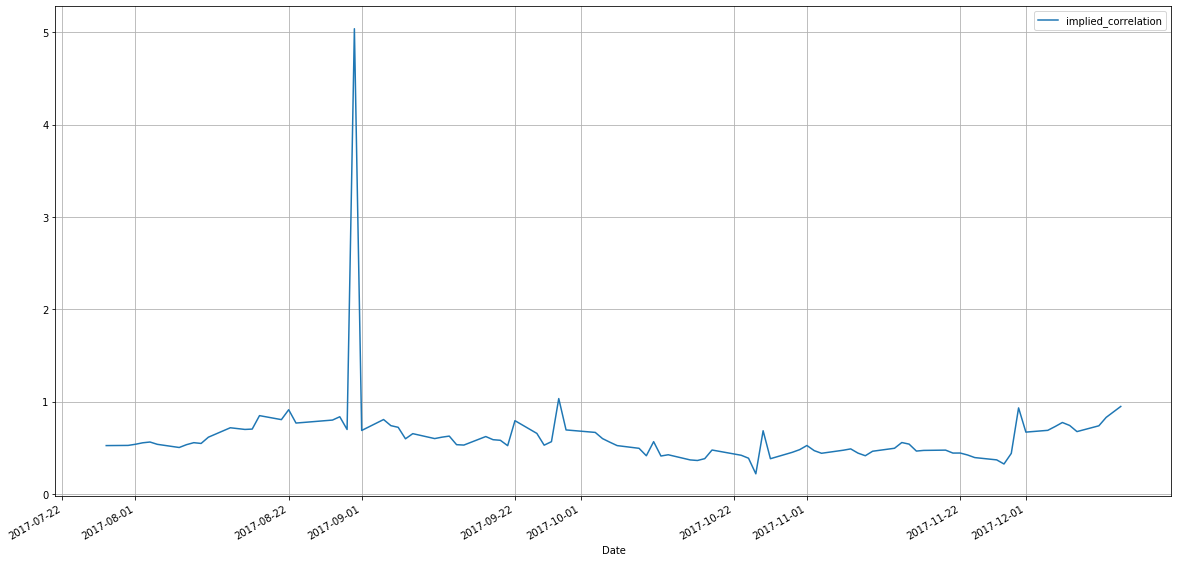

In [31]:
df.plot( grid = True , figsize = (20,10))
plt.show()

**Notice: The significant spike in the implied correlation of 5 is on the expiry day which can be ignored as our strategy does not rely on taking position on expiry date.**

## Establish options positions

Signals are generated when the implied correlation is greater than half standard deviation from the mean or when it is less than half standard deviation from the mean. When the implied correlation is high, the index implied volatility is higher than that of the constituents implied volatility and we want to establish a short volatility position on the index and simultaneously assume a long volatility position on the constituents. Likewise, when the correlation is low, the index volatility is at a discount to the constituents, thus we want to establish a long volatility position on the index and assume a short volatility position on the constituents.

We will store:
1. '+1' for long on index straddle and short on index constituents straddle 
2. Vice-versa, '-1' for short on index straddle and long on index constituents straddle
3. '0' is stored to exit the positions in index and index constituents

In [32]:
def trading_signal(df):
    df.index.column = 0

    lookback = 5
    # Moving Average
    df['moving_average'] = df['implied_correlation'].rolling(lookback).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df['implied_correlation'].rolling(lookback).std()

    df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev
    df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev

    df['long_entry'] = df.implied_correlation < df.lower_band
    df['long_exit'] = df.implied_correlation >= df.moving_average

    df['short_entry'] = df.implied_correlation > df.upper_band
    df['short_exit'] = df.implied_correlation <= df.moving_average

    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0

    expiry_dates = HDFCBANK_Opt.Expiry.unique()
    df.loc[df.index.isin(expiry_dates), 'positions_short'] = 0

    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0

    df.loc[df.index.isin(expiry_dates), 'positions_short'] = 0

    df = df.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    return df


df = trading_signal(df)
df.positions.tail()

Date
2017-12-08    1.0
2017-12-11    0.0
2017-12-12   -1.0
2017-12-13   -1.0
2017-12-14   -1.0
Name: positions, dtype: float64

## Strategy PnL

The strategy PnL is calculated by multiplying the positions with the daily PnL of the long straddle computed earlier.

In [33]:
options_data = pd.merge( options_data, df[['positions']], left_on = 'Date',
                       right_index = True, how = 'left')
options_data['strategy_PNL'] = options_data['positions']* options_data['daily_straddle_PNL']

In [34]:
options_data.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_PNL,IV,delta,positions,strategy_PNL
118,BANKNIFTY,2017-07-28,2017-08-31,CE,24900.0,382.00,24934.25,34.0,509.65,127.65,12.020111,0.522254,NaN,NaN
119,BANKNIFTY,2017-07-28,2017-08-31,PE,24900.0,355.30,24934.25,34.0,284.35,-70.95,12.268066,-0.477897,NaN,NaN
120,BANKNIFTY,2017-07-31,2017-08-31,CE,25100.0,396.60,25135.05,31.0,420.00,23.40,12.973785,0.522254,NaN,NaN
122,BANKNIFTY,2017-07-31,2017-08-31,PE,25100.0,367.45,25135.05,31.0,326.70,-40.75,13.175011,-0.477854,NaN,NaN
128,BANKNIFTY,2017-08-01,2017-08-31,CE,25200.0,366.15,25195.35,30.0,320.60,-45.55,12.786388,0.505304,NaN,NaN


Since, we need to take opposite position in the index constituents compared to index, we will multiply the positions with -1 and compute the strategy returns of the index constituents.

In [35]:
def strategy_pnl(options, df):
    options = pd.merge(options, df[['positions']], left_on='Date',
                   right_index=True, how='left')
    options['strategy_PNL'] = options.positions * options.daily_straddle_pnl
    return options

In [36]:
df.positions *= -1
HDFCBANK_Opt = strategy_pnl(HDFCBANK_Opt, df)
ICICIBANK_Opt = strategy_pnl(ICICIBANK_Opt, df)
KOTAKBANK_Opt = strategy_pnl(KOTAKBANK_Opt, df)
SBIN_Opt = strategy_pnl(SBIN_Opt, df)
AXISBANK_Opt = strategy_pnl(AXISBANK_Opt, df)
HDFCBANK_Opt.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta,positions,strategy_PNL
27,HDFCBANK,2017-12-12,2017-12-28,PE,1820.0,21.80,1823.05,16.0,24.75,2.95,15.319824,-0.472797,1.0,2.95
28,HDFCBANK,2017-12-13,2017-12-28,CE,1820.0,27.15,1822.15,15.0,35.10,7.95,17.696381,0.520276,1.0,7.95
30,HDFCBANK,2017-12-13,2017-12-28,PE,1820.0,24.75,1822.15,15.0,17.45,-7.30,17.524719,-0.479665,1.0,-7.30
36,HDFCBANK,2017-12-14,2017-12-28,CE,1840.0,23.80,1837.80,14.0,NaN,NaN,17.333984,0.492713,1.0,NaN
37,HDFCBANK,2017-12-14,2017-12-28,PE,1840.0,25.35,1837.80,14.0,NaN,NaN,16.868591,-0.507857,1.0,NaN


We add the PnL from call and put for each day to determine the strategy PnL for BankNifty and its constituents.

In [37]:
BankNifty_Returns = options_data.groupby(
    ['Date'])['strategy_PNL'].sum().to_frame()

HDFCBANK_Returns = HDFCBANK_Opt.groupby(['Date'])['strategy_PNL'].sum().to_frame()

ICICIBANK_Returns = ICICIBANK_Opt.groupby(
    ['Date'])['strategy_PNL'].sum().to_frame()

KOTAKBANK_Returns = KOTAKBANK_Opt.groupby(
    ['Date'])['strategy_PNL'].sum().to_frame()

SBIN_Returns = SBIN_Opt.groupby(['Date'])['strategy_PNL'].sum().to_frame()

AXISBANK_Returns = AXISBANK_Opt.groupby(['Date'])['strategy_PNL'].sum().to_frame()

BankNifty_Returns.tail()

,strategy_PNL
Date,
2017-12-08,-11.7
2017-12-11,0.0
2017-12-12,-68.9
2017-12-13,-64.1
2017-12-14,0.0


In [38]:
HDFCBANK_Returns.tail()

,strategy_PNL
Date,
2017-12-08,3.90
2017-12-11,0.00
2017-12-12,4.80
2017-12-13,0.65
2017-12-14,0.00


Here we compute the weighted average PnL of the BankNifty and its constituents. The weight is the weight of the stock in BankNifty.

In [39]:
strategy_pnl = HDFCBANK_Returns.strategy_PNL * HDFCBANK_Lot_Size * HDFCBANK_Wt + \
        SBIN_Returns.strategy_PNL * SBIN_Lot_Size * SBIN_Wt + \
        AXISBANK_Returns.strategy_PNL * AXISBANK_Lot_Size * AXISBANK_Wt + \
        KOTAKBANK_Returns.strategy_PNL * KOTAKBANK_Lot_Size * KOTAKBANK_Wt + \
        ICICIBANK_Returns.strategy_PNL * ICICIBANK_Lot_Size * ICICIBANK_Wt + \
        BankNifty_Returns.strategy_PNL * BankNifty_Lot_Size * BankNifty_Wt
    

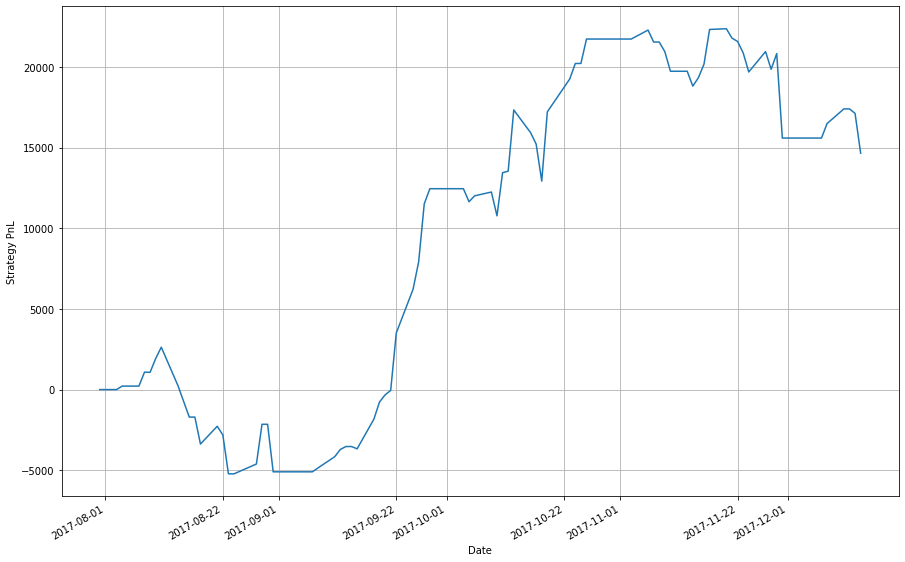

In [40]:
strategy_pnl.cumsum().shift(1).plot(figsize=(15, 10), grid = True)
plt.ylabel("Strategy PnL")
plt.show()